# LAB4: Convolutional networks
### Please write in Python using OpenCV TensorFlow and Keras libraries a code that recognizes
### three different fruits (banana, orange, lemon) in the image. The following points should be
### included:
1. Prepare a training set using basic graphic operations. The set must consist of at least 450 photos and descriptors.
2. Design a convolutional neural network (with intermediate maxpooling layers)
3. Propose proper activation functions
4. Optimize the network.
5. Perform a test classification

### The training data set and the code, along with the video generated from its optimization and
### operation, should be delivered via the Teams platform within the time specified in the task.
#### Good luck
Mateusz Andrzejewski

---

### Created by: `Jakub Góralczyk`

---


<strong><u>Type of fruits in the dataset:</u></strong>
- Lemon
- Orange
- Banana

In [34]:
# Load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import time
import gc
import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import  ModelCheckpoint
from keras import Sequential
from IPython.display import Markdown, display

In [35]:
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
np.random.seed(0) # Add random seed of training for reproducibility

def load_images_from_folder(folder, label = ""):
#  load the images
    path = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder,filename)
        if img_path is not None:
            path.append([label,img_path])
    return path

In [36]:
# Load the paths on the images
images = []
directory = "./dataset/"
for file in os.listdir(directory):
    images += load_images_from_folder(directory+file,label = file)
            
# Create a data frame with the paths and the label for each fruit
df = pd.DataFrame(images, columns = ["fruit", "path"])

# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each fruit a specific number
unique_fruit_names = sorted(df.fruit.unique())
mapped_fruit_names = dict(zip(unique_fruit_names, [t for t in range(len(unique_fruit_names))]))
df["label"] = df["fruit"].map(mapped_fruit_names)
print(mapped_fruit_names)

# Visualize the resulting data frame
df.head()

{'banana': 0, 'lemon': 1, 'orange': 2}


,fruit,path,label
0,lemon,./dataset/lemon\422.jpg,1
1,lemon,./dataset/lemon\719.jpg,1
2,banana,./dataset/banana\923.jpg,0
3,banana,./dataset/banana\943.jpg,0
4,orange,./dataset/orange\486.jpg,2


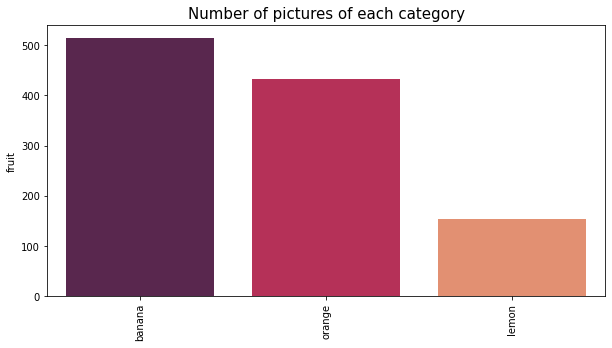

In [37]:
# Display the number of pictures of each category
vc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# Some pictures of the dataset:

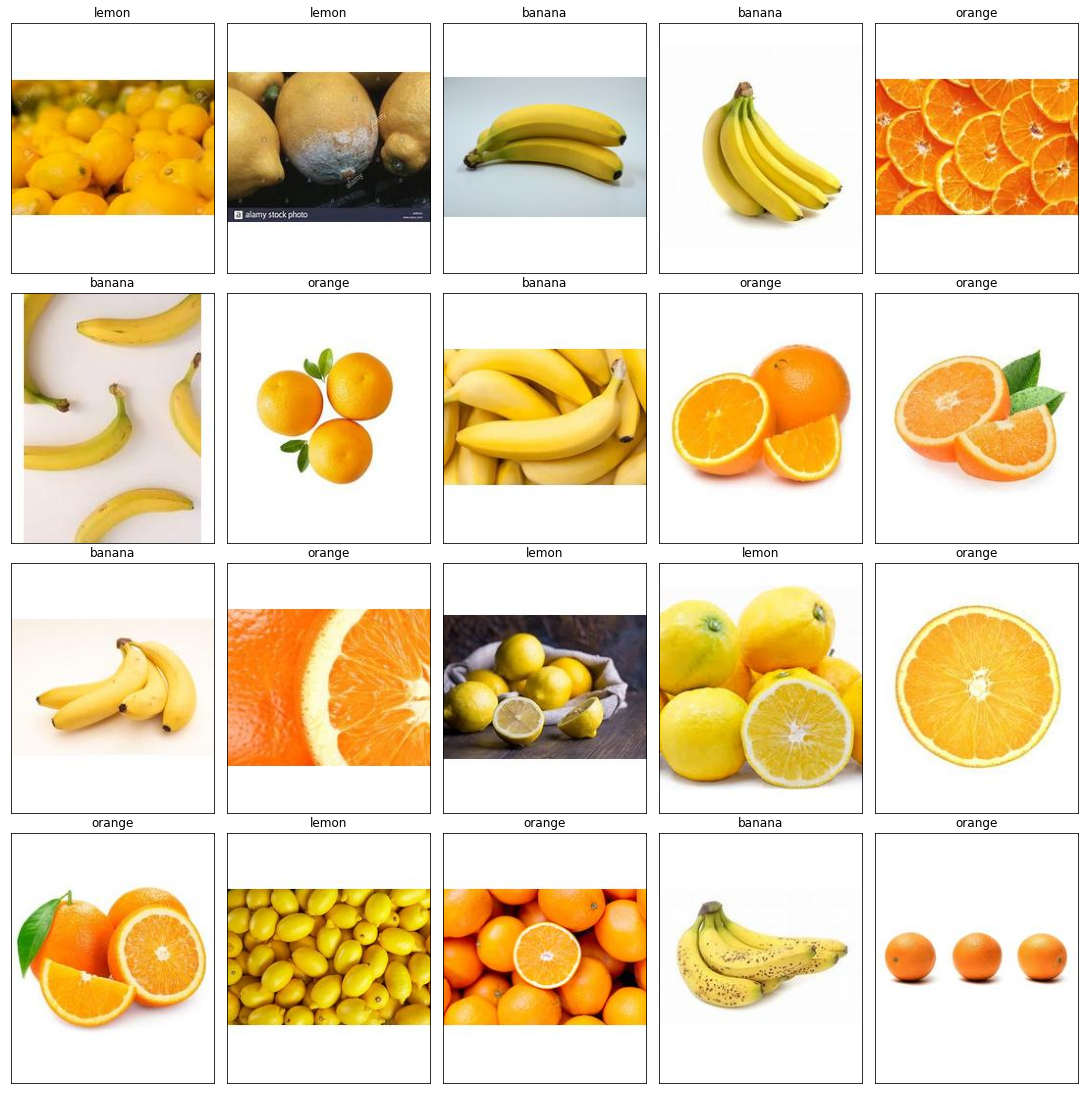

In [38]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 12)
plt.tight_layout(pad=0.0)
printmd("# Some pictures of the dataset:")
plt.show()

In [39]:
def cut_df(df, number_of_parts, part):
# Return a part of the dataframe
# For example, if a dataframe has 10 rows and we want to return a part of them
# if it is cut in two, it will return the first 5 rows or the last 5 rows depending the part wanted

# Args:
#     df (pandas.DataFrame): The dataframe to cut a part of
#     number_of_parts (int): In how many parts should the dataframe be cut
#     part (int): The part of the dataframe to return

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        label = img_labels[i]
 
        X.append(img)
        y.append(int(label))

    return (np.array(X), np.array(y))

In [40]:
def create_model():
    shape_img = (256,208,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(mapped_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    printmd("Model created.")
   
    return model

In [41]:
def from_categorical(lst):
    """
    Inverse of to_categorical
    Example: [[0,0,0,1,0], [1,0,0,0,0]] => [3,0]
    """
    lst = lst.tolist()
    anws = []
    for x in lst:
        anws.append(x.index(max(x)))
    return anws

def display_stats(y_test, pred):
# Display prediction statistics
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    pred = from_categorical(pred)
    #print(y_test_class)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    return pred

In [42]:
model = create_model()
hists = []

from keras.utils.np_utils import to_categorical
start_time = time.time()
# using 2/3 of the data for training and 1/3 for testing
X_train, y_train = load_img(cut_df(df,3,1).append(cut_df(df,3,2)))
y_train = to_categorical(y_train)

# If the ANN doesn't increase its prediction accuracy on the validation data after 
# 10 epochs, stop the training and take the best of the ANN.
callbacks = [#EarlyStopping(monitor='val_loss', patience=20),
             
             ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

model.fit(X_train, y_train, batch_size=25, epochs=100, callbacks=callbacks, validation_split = 0.15, verbose = 1)
hists.append(model.history.history)

time_model = time.time() - start_time
gc.collect() # free memory
printmd("### garbage collected.")
printmd(f"### Time to train the model: {int(time_model)} seconds")

Model created.

C:\Users\SadMachine\AppData\Local\Temp\ipykernel_43756\1588109477.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train, y_train = load_img(cut_df(df,3,1).append(cut_df(df,3,2)))


Epoch 1/100
25/25 [==============================] - 1s 31ms/step - loss: 2.3558 - accuracy: 0.4366 - val_loss: 0.9740 - val_accuracy: 0.6036
Epoch 2/100
25/25 [==============================] - 1s 23ms/step - loss: 0.9376 - accuracy: 0.5201 - val_loss: 0.9295 - val_accuracy: 0.5856
Epoch 3/100
25/25 [==============================] - 1s 25ms/step - loss: 0.8225 - accuracy: 0.6437 - val_loss: 0.8771 - val_accuracy: 0.6306
Epoch 4/100
25/25 [==============================] - 1s 25ms/step - loss: 0.5999 - accuracy: 0.7865 - val_loss: 0.5773 - val_accuracy: 0.7387
Epoch 5/100
25/25 [==============================] - 1s 25ms/step - loss: 0.5223 - accuracy: 0.8138 - val_loss: 0.4331 - val_accuracy: 0.8108
Epoch 6/100
25/25 [==============================] - 1s 23ms/step - loss: 0.5307 - accuracy: 0.8042 - val_loss: 0.5390 - val_accuracy: 0.7748
Epoch 7/100
25/25 [==============================] - 1s 23ms/step - loss: 0.4062 - accuracy: 0.8491 - val_loss: 0.4410 - val_accuracy: 0.8018
Epoch 

### garbage collected.

### Time to train the model: 59 seconds

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 256, 208, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 128, 104, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 104, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 52, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 52, 64)        36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 26, 64)      

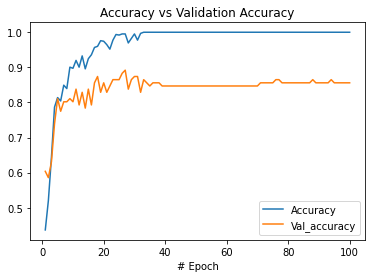

In [44]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

##  Predictions

In [45]:
# Make predictions with the model using the last 1/3 of the dataset
X, y = load_img(cut_df(df, 3, 3))
pred = (model.predict(X) > 0.5).astype("int32")
y_test = to_categorical(y).astype("int32")
# Display statistics

pred = display_stats(y_test, pred)

### Result of the predictions using 367 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       163
           1       0.79      0.70      0.75        54
           2       0.97      0.97      0.97       150

    accuracy                           0.92       367
   macro avg       0.89      0.87      0.88       367
weighted avg       0.92      0.92      0.92       367


Confusion Matrix:


[[154   7   2]
 [ 14  38   2]
 [  1   3 146]]




# Accuracy: 0.92098

## Visualize the result with pictures of fruits

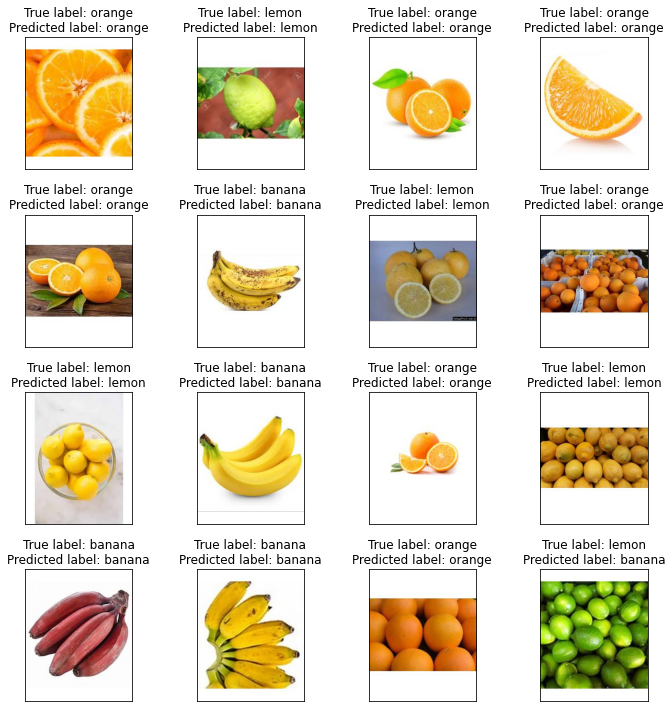

In [46]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {unique_fruit_names[y[-i]]}\nPredicted label: {unique_fruit_names[pred[-i]]}")

plt.tight_layout()
plt.show()  